*Created: 08/27/24*

*Most recent update: 09/02/24*

**Authors:** Ismael Mendoza

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_VISIBLE_DEVICES']

'1'

In [2]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [3]:
import galsim 
import jax_galsim as xgalsim

2024-09-02 13:51:29.861765: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-02 13:51:46.131581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from tqdm import tqdm

In [6]:
from functools import partial

In [7]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [8]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [9]:
from bpd.chains import inference_loop

In [10]:
jax.devices()

[CudaDevice(id=0)]

In [11]:
GPU = jax.devices('gpu')[0]

In [12]:
jax.config.update("jax_default_device", GPU)

In [13]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [14]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [15]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

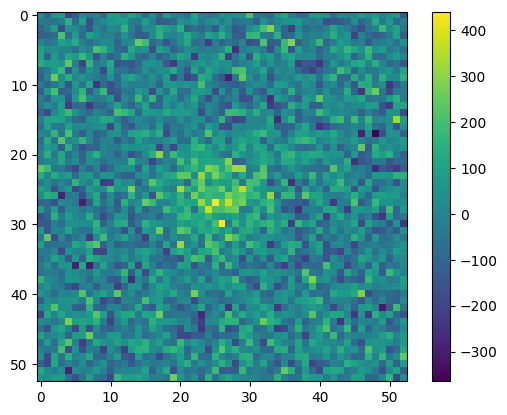

In [16]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [17]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [18]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

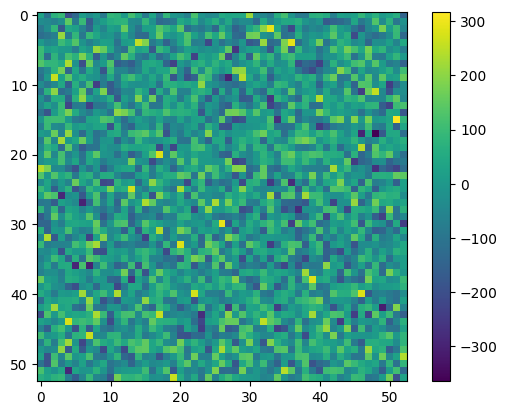

In [19]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

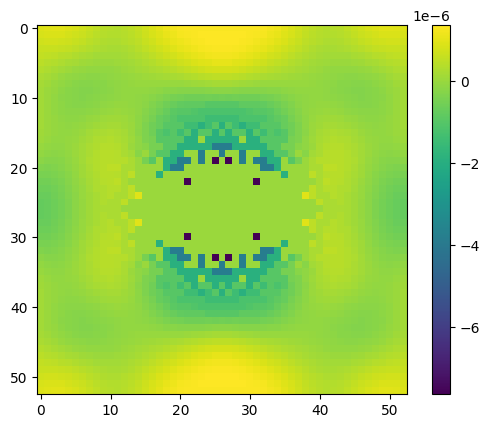

In [20]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [21]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

99.5 μs ± 2.52 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
410 μs ± 1.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [22]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [23]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 , sigma=1
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0, sigma=1
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [24]:
# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        


In [25]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 2

We want to repeat the above what each chain will have a different random initial position sampled from a ball around the truth.

We target different noise realizations. Each noise realization will have at least 4 chains to be able to estimate R-hat and ESS accurately. 

This time we also vectorize the warmup over each of the chains, i.e. no warmup sharing

**Notes**

- With max_num_doublings = 10 and bad warmup with many chains the computation can take a while...

In [26]:
SEED = 42
N_CHAINS_PER_OBJECT = 4

In [27]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=25) # maximum number of chains, 25*4, subsample below
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (25, 53, 53)


In [28]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
ball_key, sample_key, warmup_key = random.split(rng_key, 3)
print(rng_key.devices())

{CudaDevice(id=0)}


In [29]:
# what parameter space do we want to explore?
N_WARMUPS = (50, 100, 200, 500, 1000, 2000)
MAX_DOUBLINGS = 5 # maybe good enough, 10 is a lot and probably need to explore what is good in terms of warmpu first, otherwise one chain can easily get stuck
N_CHAINS = (1, 3, 5, 10, 25) # probably explodes beyond 100

In [34]:
results_dict1 = {
        n_chains:{n_warmups:{} for n_warmups in N_WARMUPS} for n_chains in N_CHAINS
}
results_dict1

{1: {50: {}, 100: {}, 200: {}, 500: {}, 1000: {}, 2000: {}},
 3: {50: {}, 100: {}, 200: {}, 500: {}, 1000: {}, 2000: {}},
 5: {50: {}, 100: {}, 200: {}, 500: {}, 1000: {}, 2000: {}},
 10: {50: {}, 100: {}, 200: {}, 500: {}, 1000: {}, 2000: {}},
 25: {50: {}, 100: {}, 200: {}, 500: {}, 1000: {}, 2000: {}}}

In [35]:
ball_keys = random.split(ball_key, 25 * N_CHAINS_PER_OBJECT)
all_init_positions = jax.vmap(sample_ball, in_axes=(0, None))(ball_keys, TRUE_PARAMS_GPU) # since we run 4 chains per noise realization in this case per object

# reshape appropriately 
all_init_positions = {p:q.reshape(-1, N_CHAINS_PER_OBJECT) for p,q in all_init_positions.items()}
all_init_positions['f'].shape

(25, 4)

In [36]:
# vmap only rng_key
def do_warmup(rng_key, init_position:dict, data, n_warmups:int,  max_num_doublings:int):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=max_num_doublings, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.80 # default
    )    
    return warmup.run(rng_key, init_position, n_warmups) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix, max_num_doublings:int, n_samples:int):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=max_num_doublings).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=n_samples) # state, info
    


In [37]:
# here we do the warmup independently for every chain regardless of the fact that we target the same data 

N_SAMPLES = 1000

print('MD=5, n_chains, n_warmup')
for n_chains in N_CHAINS:
    for n_warmups in N_WARMUPS:
        print(n_chains, n_warmups)

        # two vmaps, one for data and one for 4 chains per data
        _run_warmup = jax.vmap(
                            jax.vmap(
                                jax.jit(
                                    partial(
                                        do_warmup, n_warmups=n_warmups, max_num_doublings=MAX_DOUBLINGS
                                    )
                                ), in_axes=(0, 0, None)
                            ), in_axes=(0, 0, 0)                
        )
        _run_inference = jax.vmap(
                            jax.vmap(
                                jax.jit(
                                    partial(
                                        do_inference, max_num_doublings=MAX_DOUBLINGS, n_samples=N_SAMPLES, 
                                    )
                                ), in_axes=(0, 0, None, 0, 0)
                            ), in_axes=(0, 0, 0, 0, 0)            
        )
        # prepare random keys
        warmup_keys1 = random.split(warmup_key, n_chains)
        warmup_keys = jax.vmap(random.split, in_axes=(0, None))(warmup_keys1, N_CHAINS_PER_OBJECT)

        sample_keys1 = random.split(sample_key, n_chains)
        sample_keys = jax.vmap(random.split, in_axes=(0, None))(sample_keys1, N_CHAINS_PER_OBJECT)

        # prepare initialization 
        _init_positions = {p:q[:n_chains, :] for p,q in all_init_positions.items()}
        _data_gpu1 = data_gpu[:n_chains, :, :]


        # compilation times
        t1 = time.time()
        (_init_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(warmup_keys, _init_positions, _data_gpu1))            
        t2 = time.time()
        results_dict1[n_chains][n_warmups]['warmup_comp_time'] = t2 - t1 

        t1 = time.time()
        _ = jax.block_until_ready(_run_inference(sample_keys, _init_states, _data_gpu1, 
                                                            _tuned_params['step_size'], 
                                                            _tuned_params['inverse_mass_matrix']))
        t2 = time.time()
        results_dict1[n_chains][n_warmups]['inference_comp_time'] = t2 - t1 

        # run times
        t1 = time.time()
        (init_states, tuned_params), adapt_info = jax.block_until_ready(_run_warmup(warmup_keys, _init_positions, _data_gpu1))
        t2 = time.time()
        results_dict1[n_chains][n_warmups]['warmup_run_time'] = t2 - t1 

        t1 = time.time()
        states, infos = jax.block_until_ready(_run_inference(sample_keys, init_states, _data_gpu1, 
                                                             tuned_params['step_size'], 
                                                             tuned_params['inverse_mass_matrix']
                                                            ))
        t2 = time.time()
        results_dict1[n_chains][n_warmups]['inference_run_time'] = t2 - t1 

        # save states and info for future reference
        results_dict1[n_chains][n_warmups]['states'] = states
        results_dict1[n_chains][n_warmups]['info'] = infos
        results_dict1[n_chains][n_warmups]['adapt_info'] = adapt_info
print('DONE!')

MD=5, n_chains, n_warmup
1 50
1 100
1 200
1 500
1 1000
1 2000
3 50
3 100
3 200
3 500
3 1000
3 2000
5 50
5 100
5 200
5 500
5 1000
5 2000
10 50
10 100
10 200
10 500
10 1000
10 2000
25 50
25 100
25 200
25 500
25 1000
25 2000
DONE!


## save run

In [43]:
# jnp.save('results_benchmark-v2.npy', results_dict1)

## Diagnostic plots

In [44]:
d = jnp.load('results_benchmark-v2.npy', allow_pickle=True)[()]

In [50]:
d[25][500]['states'].position['g1'].shape

(25, 4, 1000)

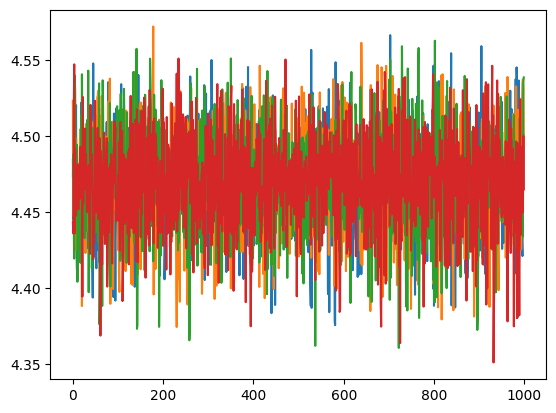

In [52]:
# example chains
plt.plot(d[5][1000]['states'].position['f'][0, 0, :])
plt.plot(d[5][1000]['states'].position['f'][0, 1, :])
plt.plot(d[5][1000]['states'].position['f'][0, 2, :])
plt.plot(d[5][1000]['states'].position['f'][0, 3, :])

In [52]:
# import pickle 
# with open('partial_results_benchmark2.pickle', 'wb') as f:
#     pickle.dump(results_dict2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
import pickle 
with open('partial_results_benchmark2.pickle', 'rb') as f:
    ex = pickle.load(f)
ex[5][10][10].keys()

dict_keys(['warmup_comp_time', 'inference_comp_time', 'warmup_run_time', 'inference_run_time', 'states', 'info'])

In [ ]:
md = 5
warmup_times = 
run_times = 